### 1. `max_depth` param

- at depth $d$, there are $2^d$ nodes
- too deep => model will try to memorize => overfit
- find optimal `max_depth`? => start from the recommended 3 and see

(array([0, 1]), array([190, 322], dtype=int64))
calculate number of fold:
total rows are 512 so the test portion should be around 102
so, k should be 4.0


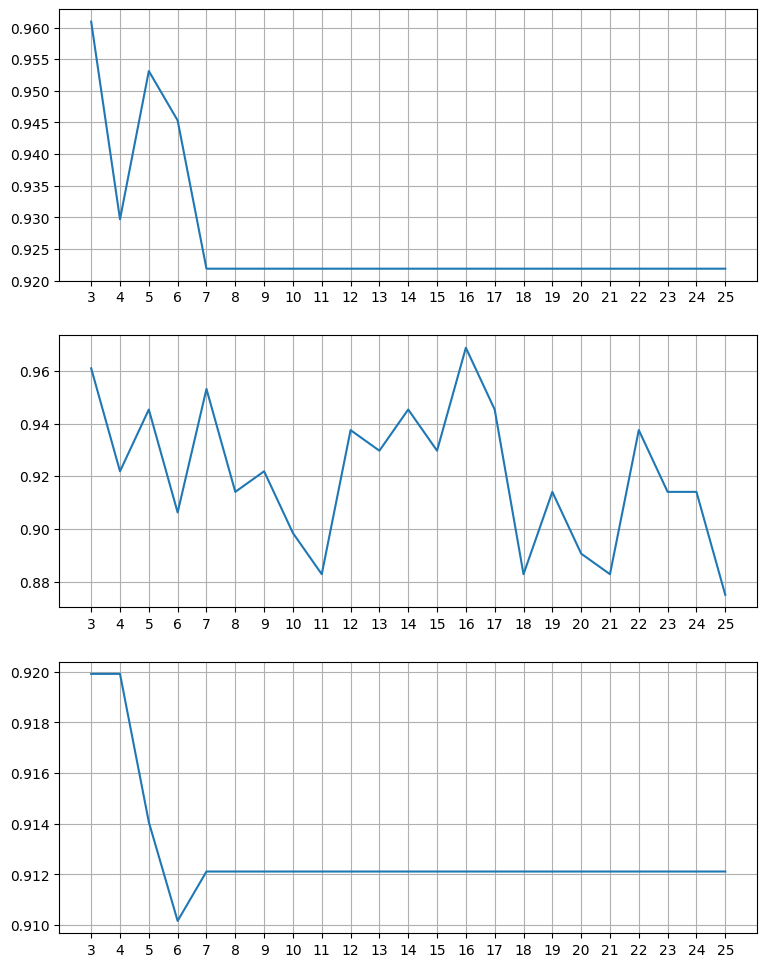

0.9473684210526315

In [27]:
import numpy as np 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

np.random.seed(0)

X_raw = load_breast_cancer().data
y_raw = load_breast_cancer().target
X, X_test, y, y_test = train_test_split(X_raw, y_raw, test_size=0.1, random_state=0)

print(np.unique(y, return_counts=True))
max_depths = range(3, 26, 1)
accs1, accs2, accs3 = [], [], []

# no cross score, no shueffle data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_valid)
    accs1.append(accuracy_score(y_pred, y_valid))

# no cross score, shueffle data
for max_depth in max_depths:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True)
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_valid)
    accs2.append(accuracy_score(y_pred, y_valid))

#  cross score, no shueffle data
print("calculate number of fold:")
print("total rows are", y.shape[0], "so the test portion should be around", round(y.shape[0] * 0.2))
k = y.shape[0] // (y.shape[0] * 0.2)
print("so, k should be", k)
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    scores = cross_val_score(dt, X, y, cv=int(k))
    accs3.append(np.mean(scores))


fig, ax = plt.subplots(3, 1, figsize=(9, 12))
ax[0].plot(max_depths, accs1)
ax[1].plot(max_depths, accs2)
ax[2].plot(max_depths, accs3)
plt.setp(ax, xticks=max_depths)
plt.show()

# choose max_depth = 3 and let's see on test (assumed completely new to model)
dt_final = DecisionTreeClassifier(max_depth=3, random_state=0)
dt_final.fit(X_train, y_train)
y_pred_test = dt_final.predict(X_test)
accuracy_score(y_pred_test, y_test)

### 2. `min_samples_split` or `min_samples_leaf`

Default = 2 and 1 respectively

Use `min_samples_split` or `min_samples_leaf` to ensure that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. Try `min_samples_leaf=5` as an initial value. If the sample size varies greatly, a float number can be used as percentage in these two parameters (`ceil(min_samples_split * n_samples)`). 

- Regressor: While `min_samples_split` can create arbitrarily small leaves, `min_samples_leaf` guarantees that each leaf has a minimum size, avoiding low-variance, over-fit leaf nodes in regression problems. 
- Classifier: For classification with few classes, `min_samples_leaf=1` is often the best choice.

Note that `min_samples_split` considers samples directly and independent of `sample_weight`, if provided (e.g. a node with m weighted samples is still treated as having exactly m samples). Consider `min_weight_fraction_leaf` or `min_impurity_decrease` if accounting for sample weights is required at splits.

### 3. Understand `.tree_`

https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#tree-structure

In [23]:
print("index of feature used to split at each node", dt_final.tree_.feature)

print("class distribution at each node in the decision tree, 0 then 1:")
dt_final.tree_.value

index of feature used to split at each node [22 27 23 -2 -2  1 -2 -2 26 -2 23 -2 -2]
class distribution at each node in the decision tree, 0 then 1:


array([[[0.35677083, 0.64322917]],

       [[0.06563707, 0.93436293]],

       [[0.01298701, 0.98701299]],

       [[0.00440529, 0.99559471]],

       [[0.5       , 0.5       ]],

       [[0.5       , 0.5       ]],

       [[0.17647059, 0.82352941]],

       [[1.        , 0.        ]],

       [[0.96      , 0.04      ]],

       [[0.        , 1.        ]],

       [[0.98360656, 0.01639344]],

       [[0.        , 1.        ]],

       [[0.99173554, 0.00826446]]])

In [24]:
n_nodes = dt_final.tree_.node_count
children_left = dt_final.tree_.children_left
children_right = dt_final.tree_.children_right
feature = dt_final.tree_.feature
threshold = dt_final.tree_.threshold
values = dt_final.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=np.around(values[i], 3),
            )
        )

The binary tree structure has 13 nodes and has the following tree structure:

node=0 is a split node with value=[[0.357 0.643]]: go to node 1 if X[:, 22] <= 113.14999771118164 else to node 8.
	node=1 is a split node with value=[[0.066 0.934]]: go to node 2 if X[:, 27] <= 0.13580000400543213 else to node 5.
		node=2 is a split node with value=[[0.013 0.987]]: go to node 3 if X[:, 23] <= 874.8500061035156 else to node 4.
			node=3 is a leaf node with value=[[0.004 0.996]].
			node=4 is a leaf node with value=[[0.5 0.5]].
		node=5 is a split node with value=[[0.5 0.5]]: go to node 6 if X[:, 1] <= 20.299999237060547 else to node 7.
			node=6 is a leaf node with value=[[0.176 0.824]].
			node=7 is a leaf node with value=[[1. 0.]].
	node=8 is a split node with value=[[0.96 0.04]]: go to node 9 if X[:, 26] <= 0.18205000460147858 else to node 10.
		node=9 is a leaf node with value=[[0. 1.]].
		node=10 is a split node with value=[[0.984 0.016]]: go to node 11 if X[:, 23] <= 820.4500122070312 el

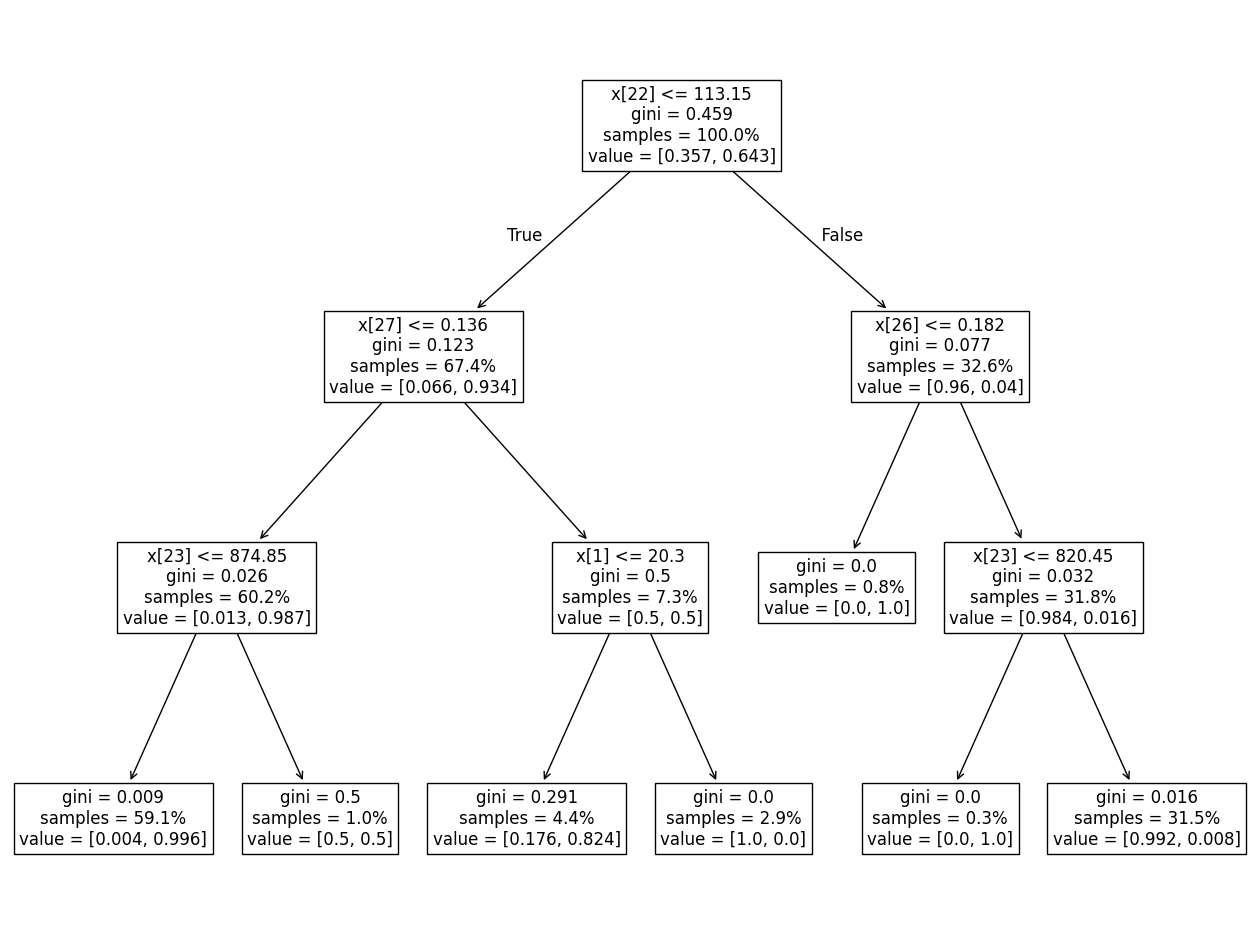

In [39]:
plt.figure(figsize=(16, 12))
plot_tree(dt_final, proportion=True, fontsize=12)
plt.show()